Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

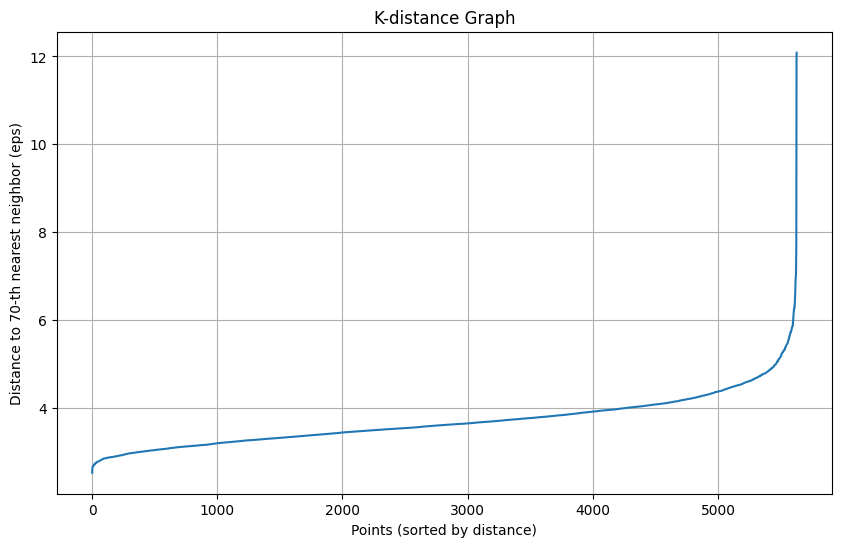


Look for the 'elbow' or 'knee' in the plot above. This is a good candidate for `eps`.
For this dataset, a value around 4.0-5.0 seems like a reasonable starting point.

Running DBSCAN with eps=4.5 and min_samples=70...

Estimated number of clusters: 1
Estimated number of noise points: 62 (1.10%)

Cluster Distribution:
Cluster
 0    5568
-1      62
Name: count, dtype: int64

Visualizing clusters using PCA for dimensionality reduction...


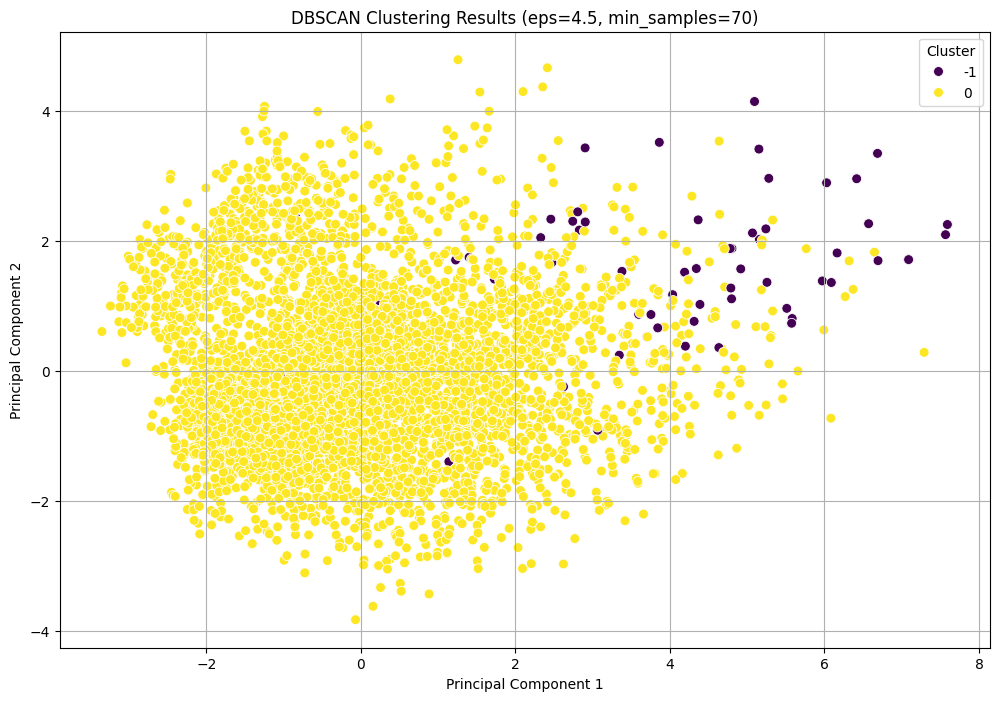


Profiling the discovered clusters (excluding noise points):

Mean of Numerical Features per Cluster:
            Churn     Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
Cluster                                                                   
0        0.165948  10.112557  1.653197        15.577393        2.930574   

         NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  \
Cluster                                                                 
0                        3.686602           3.064476         4.200611   

         Complain  OrderAmountHikeFromlastYear  CouponUsed  OrderCount  \
Cluster                                                                  
0        0.284303                    15.699455    1.671558    2.910321   

         DaySinceLastOrder  CashbackAmount  
Cluster                                     
0                 4.478376      176.686961  

Churn Rate per Cluster:
Churn           0         1
Cluster                    
0        0.83

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid NameError

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())
    print("\nDataset Info:")
    df.info()

# Cell 3: Data Preprocessing (if dataset loaded)
if not df.empty:
    # Keep a copy of the original data for later analysis
    df_original = df.copy()

    # Drop CustomerID as it is just an identifier
    if 'CustomerID' in df.columns:
        df = df.drop('CustomerID', axis=1)

    # Handle missing values (impute)
    print("\nMissing values before handling:")
    print(df.isnull().sum())
    
    # Simple imputation strategy
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].fillna(df[column].mode()[0])
    for column in df.select_dtypes(include=[np.number]).columns:
        df[column] = df[column].fillna(df[column].median())
    
    print("\nMissing values after handling:")
    print(df.isnull().sum())

    # Identify categorical and numerical features
    # Note: We include 'Churn' here for preprocessing as DBSCAN is unsupervised.
    # We will simply ignore it during the model fitting.
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("\nCategorical Features:", categorical_features)
    print("Numerical Features:", numerical_features)

    # Create a full preprocessing pipeline
    # 1. OneHotEncode categorical features
    # 2. StandardScaler for all features (DBSCAN is distance-based and sensitive to scale)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Create a pipeline to apply the transformations
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # Fit and transform the data
    print("\nPreprocessing and scaling the data...")
    X_processed = pipeline.fit_transform(df)
    print("Data processing complete.")
    print("Shape of processed data:", X_processed.shape)


# Cell 4: Determine Optimal DBSCAN `eps` Parameter (if data is processed)
if 'X_processed' in locals():
    # A common way to find a good `eps` is to use a k-distance graph.
    # We plot the distance to the k-th nearest neighbor for all points, where k = min_samples.
    # The "elbow" of the curve suggests a good value for `eps`.
    
    # min_samples is often set to 2 * number of dimensions
    min_samples = 2 * X_processed.shape[1]
    print(f"\nSetting min_samples to {min_samples} (2 * number of dimensions)")
    
    # Calculate the distance to the k-th nearest neighbor
    print("Calculating k-distance graph to find optimal `eps`...")
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(X_processed)
    distances, indices = neighbors_fit.kneighbors(X_processed)
    
    # Sort distances and plot
    distances = np.sort(distances[:, min_samples-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title('K-distance Graph')
    plt.xlabel('Points (sorted by distance)')
    plt.ylabel(f'Distance to {min_samples}-th nearest neighbor (eps)')
    plt.grid(True)
    plt.show()
    
    print("\nLook for the 'elbow' or 'knee' in the plot above. This is a good candidate for `eps`.")
    print("For this dataset, a value around 4.0-5.0 seems like a reasonable starting point.")


# Cell 5: Apply DBSCAN and Analyze Cluster Results (if data is processed)
if 'X_processed' in locals():
    # From the plot above, let's choose an `eps` value.
    # This might require some tuning. Let's start with 4.5.
    chosen_eps = 4.5
    
    print(f"\nRunning DBSCAN with eps={chosen_eps} and min_samples={min_samples}...")
    dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_processed)
    
    # Add cluster labels to the original dataframe for analysis
    df_original['Cluster'] = clusters
    
    # Analyze the results
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"\nEstimated number of clusters: {n_clusters}")
    print(f"Estimated number of noise points: {n_noise} ({n_noise / len(clusters):.2%})")
    
    # Show the distribution of points in clusters
    print("\nCluster Distribution:")
    print(df_original['Cluster'].value_counts())


# Cell 6: Visualize DBSCAN Clusters using PCA (if clusters are found)
if 'df_original' in locals():
    print("\nVisualizing clusters using PCA for dimensionality reduction...")
    
    # Reduce the high-dimensional processed data to 2 dimensions for plotting
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_processed)
    
    # Create a DataFrame for plotting
    df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_pca['Cluster'] = df_original['Cluster']

    # Plot the results
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=50)
    
    plt.title(f'DBSCAN Clustering Results (eps={chosen_eps}, min_samples={min_samples})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()


# Cell 7: Profile the Clusters (if clusters are found)
if 'df_original' in locals() and n_clusters > 0:
    # Exclude noise points for profiling
    clusters_profile = df_original[df_original['Cluster'] != -1]
    
    if not clusters_profile.empty:
        print("\nProfiling the discovered clusters (excluding noise points):")
        
        # Profile numerical features by cluster
        numerical_profile = clusters_profile.groupby('Cluster')[numerical_features].mean()
        print("\nMean of Numerical Features per Cluster:")
        print(numerical_profile)
        
        # You can also investigate the 'Churn' rate per cluster
        churn_profile = clusters_profile.groupby('Cluster')['Churn'].value_counts(normalize=True).unstack()
        print("\nChurn Rate per Cluster:")
        print(churn_profile)
    else:
        print("\nNo clusters were found to profile (all points were considered noise).")
        print("Try adjusting the `eps` and `min_samples` parameters.")